# Preprocessing

This notebook discusses the different preprocessing methods used for machine learning. The methods will be used from libraries like `sklearn` and `pandas`.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
%matplotlib inline

In [3]:
dataset = load_boston()
X, y = dataset.data, dataset.target
features = dataset.feature_names

In [4]:
dataset_table = pd.read_csv("assets/boston.csv")
dataset_table.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MDEV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### 1. Scaling

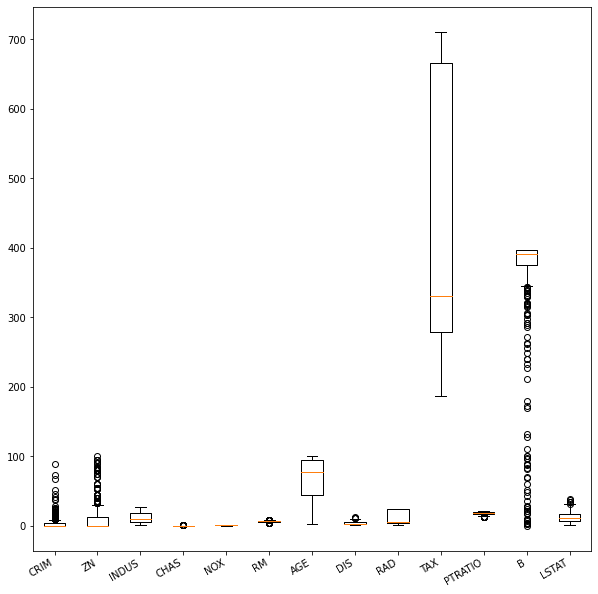

In [5]:
plt.figure(figsize=(10, 10))
plt.boxplot(X)
plt.xticks(np.arange(1, X.shape[1] + 1), features, rotation = 30, ha = 'right');

The box plot shows that the features are of different scales, and most of them are not normally distributed.

<img src="assets/img/effect-of-scaling-knn.png">

For the above knn classification, the x-axis and y-axis are totally different in the range. Using such scales in KNN would result in neglecting the y-axis data by the classifier as the small changes in the x-axis numerically overcome the big differences on the y-axis when it's clear that we can see 2 classes differ in a specific range of the y-axis.

When using a zero-mean unit-variance scaling for both axes. The KNN classification performs much better.

#### Scaling Techniques in `sklearn`:

* Standard Scaler (Most common one) $$x' = \frac{x - \mu}{\sigma}$$
* Min-Max Scaler (Useful If you have fixed boundaries)  $$x' = \frac{x - new\_min}{new\_max - new\_min}$$
* Robust Scaler (Same as standard Scaler but uses median and quartiles) (Useful if you have many outliers) $$x' = \frac{x - median}{q3 - q1}$$
* Normalizer (devides by the sum of the features)

> #### Sparse Data
> They are data with many zeros-only in non-zero entries. When scaling with any techniques that includes subtraction will make the data dense which is non-reasonable for memory storage. **Don't center, scale only (`MaxAbsScaler`)**

#### Standard Scaler Example

In [6]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

ridge_regressor = Ridge()  # regression algorithm, don't care about it right now...
ridge_regressor.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)
ridge_regressor.score(X_test_scaled, y_test)

0.6345884564889053

**NOTE**: Call the scaler `fit` method only for the training data. Not the whole data, before splitting, or the test set.

#### Information Leakage

<img src="assets/img/information-leakage.png">

When applying the cross-validation, you should only fit the classifier or the scaler to the training folds away of the folds used for validation that are only used in prediction of the model or transformed using already-fit scaler from the training folds.

When finalizing the machine learning model, for example to the production, you now can fit the whole training data (training and validation parts) into the model or scaler away from the test set which will be used only for transforming or prediction.

### 2. Pipelines

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

ridge = Ridge()
ridge.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)
ridge.score(X_test_scaled, y_test)


0.6345884564889053

With pipelines, we can chain steps (e.g., scaling and regression) to a single model. When calling the `fit` method from the pipeline object, it will call the `fit` method of its steps (i.e., scaler and regressor). This pipeline object can be used in a cross-validation. This way we are sure that no inforamtion leakage will happen in the cross-validation process as the `fit` method will be called only for the training folds.

<img src="assets/img/pipeline.png">

In [24]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(StandardScaler(), Ridge())
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.6345884564889053

To name the steps yourself,

In [28]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", KNeighborsRegressor())
])

scores = cross_val_score(pipeline, X_train, y_train, cv=10)
print(np.mean(scores), np.std(scores))

0.7455608822349746 0.10625173604969354


Same for grid search. When specifying the parameters you want to search for, you should name the parameters grid when using pipeline as following:

<center>

**step name** + "__" (double underscore) + **parameter inside that step**

</center>

In [29]:
from sklearn.model_selection import GridSearchCV

knn_pipe = make_pipeline(StandardScaler(), KNeighborsRegressor())

param_grid = {'kneighborsregressor__n_neighbors': range(1, 10)}
grid = GridSearchCV(knn_pipe, param_grid, cv=10)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.score(X_test, y_test))

{'kneighborsregressor__n_neighbors': 7}
0.5999825126971097


Notice that you'll replace `kneighborsregressor__n_neighbors` with `regressor__n_neighbors` if you name the regression step as we have done few cells above.

### 3. Categorical Features

In [30]:
df = pd.DataFrame(
    {'boro': ['Manhattan', 'Queens', 'Manhattan', 'Brooklyn', 'Brooklyn', 'Bronx'],
     'vegan': ['No', 'No','No','Yes', 'Yes', 'No']}
)

df

,boro,vegan
0,Manhattan,No
1,Queens,No
2,Manhattan,No
3,Brooklyn,Yes
4,Brooklyn,Yes
5,Bronx,No


For `boro`, we need to convert this categorial feature to numbers. To do that, we can use ordinal encoding using `pandas` `category` type.

In [32]:
df['boro_ordinal'] = df['boro'].astype('category').cat.codes
df

,boro,vegan,boro_ordinal
0,Manhattan,No,2
1,Queens,No,3
2,Manhattan,No,2
3,Brooklyn,Yes,1
4,Brooklyn,Yes,1
5,Bronx,No,0


But ordinal encoding give each borough a numerical value depending on its alphabetical order (or the order of appearance), which is not logical. So, we need to process the `boro_ordinal` feature to be non-ordinal or **nominal**. We can do that using dummy encoding.

In [33]:
pd.get_dummies(df, columns=['boro'])

,vegan,boro_ordinal,boro_Bronx,boro_Brooklyn,boro_Manhattan,boro_Queens
0,No,2,0,0,1,0
1,No,3,0,0,0,1
2,No,2,0,0,1,0
3,Yes,1,0,1,0,0
4,Yes,1,0,1,0,0
5,No,0,1,0,0,0


In [34]:
# works the same for already oridnal-encoded catergorial features (with different generated feature names)
pd.get_dummies(df, columns=['boro_ordinal'])

,boro,vegan,boro_ordinal_0,boro_ordinal_1,boro_ordinal_2,boro_ordinal_3
0,Manhattan,No,0,0,1,0
1,Queens,No,0,0,0,1
2,Manhattan,No,0,0,1,0
3,Brooklyn,Yes,0,1,0,0
4,Brooklyn,Yes,0,1,0,0
5,Bronx,No,1,0,0,0


A problem may occur when nominal - dummy - encode categorial features,

* When encode categories in a subset of the dataset and encode again when you reach another subset, this may be a problem if a cateogry exist in the second subset that didn't in the first one
* When the order of the categories in the second subset isn't the same as the first one.

One way is to ensure all posibilities of the cateogries of the feature before encoding, which isn't 100% practical. Another way is using the `pandas` `cateogrial` columns

In [36]:
df = pd.DataFrame({
    'salary': [103, 89, 142, 54, 63, 219],
    'boro': ['Manhattan', 'Queens', 'Manhattan','Brooklyn', 'Brooklyn', 'Bronx']
})

df

,salary,boro
0,103,Manhattan
1,89,Queens
2,142,Manhattan
3,54,Brooklyn
4,63,Brooklyn
5,219,Bronx


In [37]:
# define that the boro feature is categorial, which when encoded will be transformed much properly than before
df['boro'] = pd.Categorical(df['boro'], categories=['Manhattan', 'Queens', 'Brooklyn', 'Bronx', 'Staten Island'])

# encode it now
pd.get_dummies(df)

,salary,boro_Manhattan,boro_Queens,boro_Brooklyn,boro_Bronx,boro_Staten Island
0,103,1,0,0,0,0
1,89,0,1,0,0,0
2,142,1,0,0,0,0
3,54,0,0,1,0,0
4,63,0,0,1,0,0
5,219,0,0,0,1,0


Notice that `boro_Staten Island` appeared even thought Stated Island isn't in the original `df`.

Another way of handling the categorial features is using the `OneHotEncoder` class from `sklearn`. 

In [45]:
from sklearn.preprocessing import OneHotEncoder

df = pd.DataFrame({
    'salary': [103, 89, 142, 54, 63, 219],
    'boro': ['Manhattan', 'Queens', 'Manhattan', 'Brooklyn', 'Brooklyn', 'Bronx']
})

ohe = OneHotEncoder() # OneHotEncoder assumes all passed data are categorial. Not the best case :(
ohe.fit(df)
ohe.transform(df).toarray() # toarray() used to convert the sparse array object to numpy array. Check `type(ohe.transform(df))``

array([[0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]])

To look in more detail about the difference between `pd.get_dummies` and `sklearn.preprocessing.OneHotEncoder` check [this](https://albertum.medium.com/preprocessing-onehotencoder-vs-pandas-get-dummies-3de1f3d77dcc)

Best solution ? Column Transformer from `make_column_transformer`

In [51]:
# this line creates a pandas series of the feature name and if it was categorial or not
categorial = df.dtypes == object
print(categorial)

salary    False
boro       True
dtype: bool


In [53]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

preprocess = make_column_transformer(
    (StandardScaler(), ~categorial), # for all not cateogrial features, apply scaling
    (OneHotEncoder(), categorial)    # for all cateogrial features, apply the one hot encoding
)

model = make_pipeline(preprocess, LogisticRegression())

Regarding the dummy variable trap and colinearity stuff, check these links [link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#:~:text=drop%7B%E2%80%98first%E2%80%99%2C%20%E2%80%98if_binary,or%20regression%20models.) and
[link2](https://stackoverflow.com/a/47433783) to know when to drop a dummy variable to assure no colinearity occurs between the features